# GAN Project
## Liz Parker, Colin Craighead, and Aren Dalloul

Our project topic is building a Generative Adversarial Network (GAN). A GAN is a machine learning framework introduced by Ian Goodfellow in 2014. The purpose of a GAN is to generate data that follows a similar statistical distribution to the provided training data. GANs are very powerful, because they can mimic any distribution of data. For our project we are generating images based on the Stanford Dog Dataset. A GAN is made up of two neural network models: A generator and a discriminator. The generator creates images, and the discriminator classifies a provided image as “real” or generated. These two models are “adversaries” pitted against each other in training. 

The goal of our project is to code a GAN and use it to generate images of dogs. In doing so, we hope to learn about the training techniques used to build a GAN and overcome the training challenges of two networks competing with each other. 

# Data Source
We are using the [Stanford Dog Dataset](http://vision.stanford.edu/aditya86/ImageNetDogs/). It includes NUM colored images of NUM breeds of dogs. The images are in .jpg format, but we also use a provided .mat file to more easily load the data into a pandas dataframe. We use the Keras preprocessing and Pillow libraries to load the .jpg images into an array format that can be used as input for a neural network model. 

In [1]:
#CLEAN UP IMPORTS !

# numpy
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
# for operate list
import operator
from functools import reduce
# for models
from keras.models import Sequential, Model
from keras.layers import * # Dense, Conv2D, Flatten, Dropout, LeakyRelu
from keras.optimizers import Adam, SGD
# tensorflow.keras.utils.vis_utils import plot_model
from keras.preprocessing.image import ImageDataGenerator
import keras.preprocessing.image as img
import scipy.io
from PIL import Image
import xml.etree.ElementTree as ET 
from keras.models import load_model
# for plot images
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
PATH_TRAIN_IMAGE = './images'
SHAPE_IMAGE = (64, 64, 3)
BATCH_SIZE = 32
# size of the latent space
latent_dim = 100
num_epoch = 3

In [3]:
#Load data from .mat file
train_mat = scipy.io.loadmat("data/train_data.mat")

In [4]:
def unpack_mat(mat, train_or_test):
    df = pd.DataFrame()
    paths = []
    crops = []
    num_datapoints = len(mat[train_or_test][0][0][0])
    for i in range(num_datapoints):
        path = "images/" + mat[train_or_test][0][0][0][i][0][0]
        paths.append(path)
        ano_path = "Annotation/" + mat[train_or_test]['annotation_list'][0][0][i][0][0]
        tree = ET.parse(ano_path)
        root = tree.getroot()
        objects = root.findall('object')
        for o in objects:
            bndbox = o.find('bndbox') 
            xmin = int(bndbox.find('xmin').text)
            ymin = int(bndbox.find('ymin').text)
            xmax = int(bndbox.find('xmax').text)
            ymax = int(bndbox.find('ymax').text)
            w = np.min((xmax - xmin, ymax - ymin))
            crop = (xmin, ymin, xmin+w, ymin+w)
        crops.append(crop)
    df['path'] = paths
    df['crops'] = crops
    return df

In [5]:
#Unpack into pandas dataframe
train_df = unpack_mat(train_mat, 'train_info')
train_df.head()

,path,crops
0,images/n02085620-Chihuahua/n02085620_5927.jpg,"(30, 14, 236, 220)"
1,images/n02085620-Chihuahua/n02085620_4441.jpg,"(107, 110, 296, 299)"
2,images/n02085620-Chihuahua/n02085620_1502.jpg,"(51, 13, 369, 331)"
3,images/n02085620-Chihuahua/n02085620_1916.jpg,"(8, 7, 398, 397)"
4,images/n02085620-Chihuahua/n02085620_13151.jpg,"(176, 29, 379, 232)"


# Data Cleaning
The Stanford Dog dataset was fairly clean, but we performed some additional cleaning. First we found and removed one "bad dog" image that had 4 channels instead of the desired 3. We also resized, cropped, and normalized the images, but this was after some exploratory data analysis of the dataset image sizes. 

In [6]:
#Data cleaning
#Find any image with improper size
for index, row in train_df.iterrows():
    s = img.img_to_array(Image.open(row['path']).crop(row['crops']).resize((64,64))).shape
    if(s != (64,64,3)):
        print("Bad index",index)
        print("Size", s)
        print("Path", row['path'])

Bad index 7904
Size (64, 64, 4)
Path images/n02105855-Shetland_sheepdog/n02105855_2933.jpg


In [7]:
#Remove bad dog from the dataset
train_df = train_df[train_df['path'] != 'images/n02105855-Shetland_sheepdog/n02105855_2933.jpg']
#Convert images in the dataset into array of pixel values
X_train = np.array([img.img_to_array(Image.open(row['path'])) for index, row in train_df.iterrows()])

# Exploratory Data Analysis
For EDA we plotted the dataset image heights and widths. This showed a large range of image sizes, with a fairly large average height and width.

In [8]:
#EDA 
heights = [x.shape[0] for x in X_train]
widths = [x.shape[1] for x in X_train]
avgHeight = np.mean(heights)
avgWidth = np.mean(widths)

Average image height is: 386.0


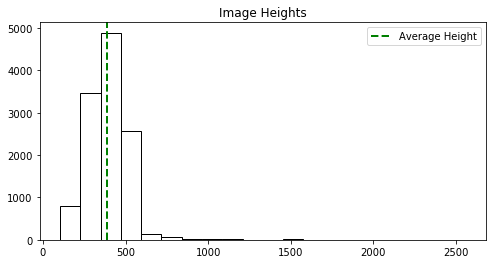

In [9]:
# Plot Histogram of image heights
print("Average image height is:", round(avgHeight))
fig = plt.figure(figsize=(8, 4))
ax = fig.add_subplot()
ax.hist(heights, bins=20, range=(np.min(heights), np.max(heights)), color='white',  edgecolor='black')
ax.set_title("Image Heights")
ax.axvline(x = avgHeight, linewidth=2, color='g', ls = "--", label = "Average Height")
ax.legend()

Average image width is: 443.0


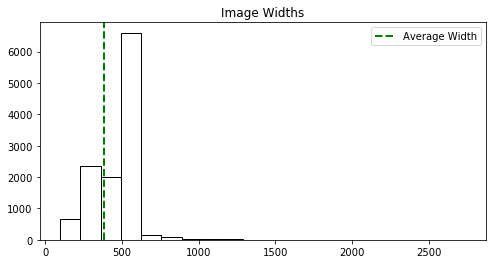

In [10]:
# Plot Histogram of image widths
print("Average image width is:", round(avgWidth))
fig = plt.figure(figsize=(8, 4))
ax = fig.add_subplot()
ax.hist(widths, bins=20, range=(np.min(widths), np.max(widths)), color='white',  edgecolor='black')
ax.set_title("Image Widths")
ax.axvline(x = avgHeight, linewidth=2, color='g', ls = "--", label = "Average Width")
ax.legend()

For further image preprocessing, we resize and crop the images to a uniform 64 by 64 size. We then calculate and display a mean image for the dataset. The mean image is mostly uninformative, but suggests images trend towards lighter, warmer colors. 

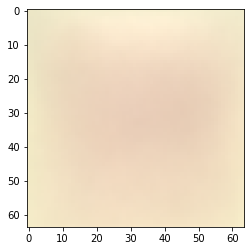

In [11]:
X_train = np.array([img.img_to_array(Image.open(row['path']).crop(row['crops']).resize((64,64))) for index, row in train_df.iterrows()])
aggregate_image = np.mean(X_train, axis=0)
plt.imshow(img.array_to_img(aggregate_image))

Finally, we normalize the dataset, because...
# WHY?

In [12]:
#Methods to normalize and denormalize training data
# puts pixel values between -1, 1
def normalize_image(image):
    image = np.asarray(image, np.float32)
    return image / 127.5 - 1

In [13]:
# moves pixels back to (0, 1)
def denormalize_image(image):
    return ((image+1)*127.5).astype(np.uint8)

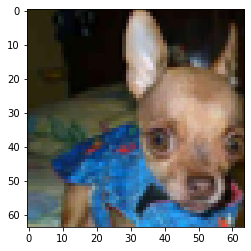

In [14]:
X_train = normalize_image(X_train)
plt.imshow(denormalize_image(X_train[0]))

In [15]:
# returns numbers between .8 and 1.0
# this will then be multipled by the label 1.0 to smooth it over
def label_smooth_factor(size):
    return np.random.rand(size)/5 + .8

In [16]:
# Switches Some images to the oposite group
def swap_group(prob_flip,size,real_images_batch,fake_images_batch):
    for i in range(size):
        flip = np.random.rand()
        if(flip<prob_flip):
            holder = real_images_batch[i]
            real_images_batch[i] = fake_images_batch[i]
            fake_images_batch[i] = holder
    return real_images_batch, fake_images_batch

In [17]:
#Method to access a sample of real dataset 
def generate_real_samples(n_samples=BATCH_SIZE):
    return X_train[np.random.randint(0, X_train.shape[0], size=n_samples)], np.reshape(np.ones(n_samples)*label_smooth_factor(n_samples),(n_samples,1))

In [18]:
#Method to print images
def show_images(ary, rows, cols):
    plt.figure(figsize=(cols*3, rows*3))
    for row in range(rows):
        for col in range(cols):
            plt.subplot(rows, cols, row*cols+col+1)
            img = (ary[row*cols+col, :] + 1) / 2
            plt.axis('off')
            plt.title(f'{row*cols+col}')
            plt.imshow(img)
    plt.show()

shape of data: (32, 64, 64, 3)
min, max of data: -1.0 1.0
shape of y (32, 1)
min, max of y 0.805287637362892 0.9943063889902855
head 5 of y [[0.99430639]
 [0.83249301]
 [0.84740157]
 [0.88126828]
 [0.99103389]]


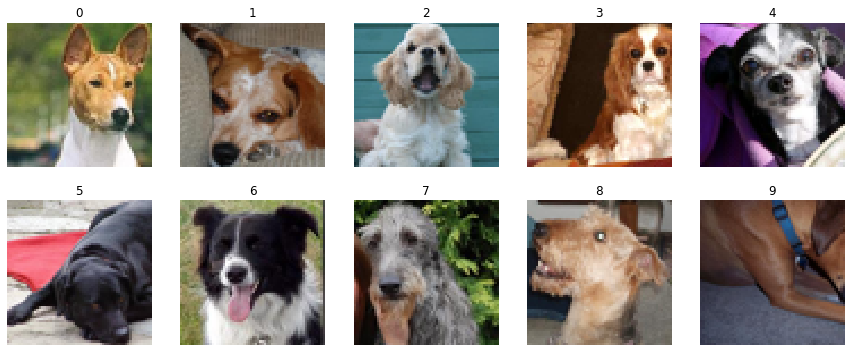

In [19]:
#Look at preprocessed and clean training data
data, y = generate_real_samples()
print('shape of data:', data.shape) # => (32, 64, 64, 3)
print('min, max of data:', data.min(), data.max()) # => 0.0 1.0
print('shape of y', y.shape) # => (32, 1)
print('min, max of y', y.min(), y.max()) # => 1.0 1.0
print('head 5 of y', y[:5]) # => [[1.] [1.] ...]
show_images(data,2, 5)

# END Liz's Data preprocessing and EDA edits

In [20]:
def define_discriminator():
    model = Sequential([
        InputLayer(input_shape=SHAPE_IMAGE),
        
        Conv2D(32, kernel_size=3, strides=2, padding='same'),
        LeakyReLU(alpha=0.2),
        BatchNormalization(momentum=0.8),
        
        Conv2D(64, kernel_size=3, strides=2, padding='same'),
        LeakyReLU(alpha=0.2),
        BatchNormalization(momentum=0.8),
        
        Conv2D(128, kernel_size=3, strides=2, padding='same'),
        LeakyReLU(alpha=0.2),
        Dropout(0.10),
        BatchNormalization(momentum=0.8),
        
        Conv2D(256, kernel_size=3, strides=2, padding='same'),
        LeakyReLU(alpha=0.2),
        Dropout(0.10),
        BatchNormalization(momentum=0.8),
        
        Conv2D(512, kernel_size=3, strides=2, padding='same'),
        LeakyReLU(alpha=0.2),
        BatchNormalization(momentum=0.8),
        Flatten(),
        Dense(1, activation='sigmoid')
    ])
    
    return model

In [21]:
# compile discriminator
discriminator = define_discriminator()
discriminator_opt = Adam(lr=0.0002, beta_1=0.5)
discriminator.compile(loss='binary_crossentropy', optimizer=discriminator_opt)
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 16, 16, 64)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 16, 16, 64)        256       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 128)        

In [22]:
def define_generator():
    model = Sequential([
        Dense((64*8*8), input_shape=(latent_dim,)),
        Reshape((8,8,64)),
        LeakyReLU(alpha=0.2),
        BatchNormalization(momentum=0.8),
        # upsample to 16x16
        UpSampling2D(),
        Conv2D(64, kernel_size=3, padding='same'),
        LeakyReLU(alpha=0.2),
        BatchNormalization(momentum=0.8),
        # upsample to 32x32
        UpSampling2D(),
        Conv2D(32, kernel_size=3, padding='same'),
        LeakyReLU(alpha=0.2),
        BatchNormalization(momentum=0.8),
        # upsample to 64x64
        UpSampling2D(),
        Conv2D(16, kernel_size=3, padding='same'),
        LeakyReLU(alpha=0.2),
        BatchNormalization(momentum=0.8),
        Conv2D(3, kernel_size=3, padding='same'),
        Activation('tanh'),
    ])
    
    return model

In [23]:
# make generator
generator = define_generator()
generator.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 4096)              413696    
_________________________________________________________________
reshape_1 (Reshape)          (None, 8, 8, 64)          0         
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 8, 8, 64)          0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 8, 8, 64)          256       
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 16, 16, 64)        36928     
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 16, 16, 64)       

In [24]:
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
    noize = np.random.normal(0.0, 1.0, (n_samples, latent_dim))
    return noize

In [25]:
# use the generator to generate n fake examples, with class labels
def generate_fake_samples(g_model, latent_dim, n_samples):
    # generate points in latent space
    x_input = generate_latent_points(latent_dim, n_samples)
    # predict outputs
    X = g_model.predict(x_input)
    # create 'fake' class labels (0)
    y = np.zeros((n_samples, 1))
    return X, y

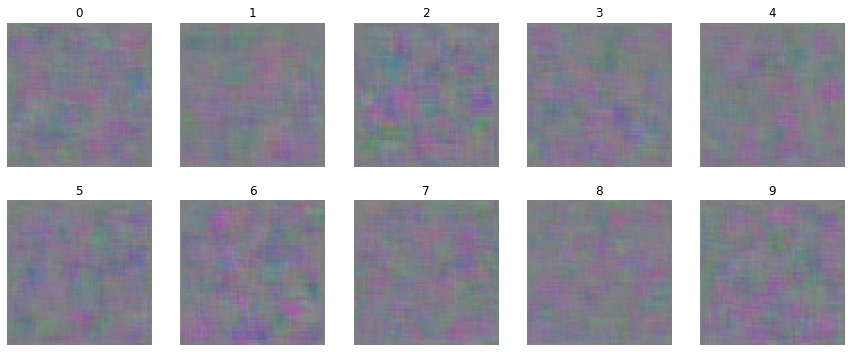

In [26]:
# generator output test
X, y = generate_fake_samples(generator, latent_dim, 10)
show_images(X, 2, 5)

In [27]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(generator, discriminator):
    discriminator.trainable = False # makes sure the only generator weights are changed when the gan is being trained

    # connect them
    model = Sequential([
        InputLayer(input_shape=(latent_dim,)),
        generator,
        discriminator
    ])
    
    return model

In [28]:
# compile gan
gan = define_gan(generator, discriminator)
# compile model
opt = Adam(lr=0.0002, beta_1=0.5)
gan.compile(loss='binary_crossentropy', optimizer=opt)
gan.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_2 (Sequential)    (None, 64, 64, 3)         474851    
_________________________________________________________________
sequential_1 (Sequential)    (None, 1)                 1574593   
Total params: 2,049,444
Trainable params: 474,499
Non-trainable params: 1,574,945
_________________________________________________________________


In [29]:
def plot_images(generator, size=10, dim=(5,5), figsize=(10,10)):
    generated_images, _ = generate_fake_samples(generator, latent_dim, size)

    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(denormalize_image(generated_images[i]), interpolation='nearest')
        plt.axis('off')

    plt.tight_layout()
    plt.show()
    
def plot_loss(epoch, g_losses, d_losses):
    plt.figure(figsize=(10,5))
    plt.title("Loss, Epochs 0-" + str(epoch))
    plt.plot(g_losses,label="Generator")
    plt.plot(d_losses,label="Discriminator")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

C:\Users\Colin\AppData\Local\Programs\Python\Python37\lib\site-packages\keras\engine\training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
C:\Users\Colin\AppData\Local\Programs\Python\Python37\lib\site-packages\keras\engine\training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
C:\Users\Colin\AppData\Local\Programs\Python\Python37\lib\site-packages\keras\engine\training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Epoch 5


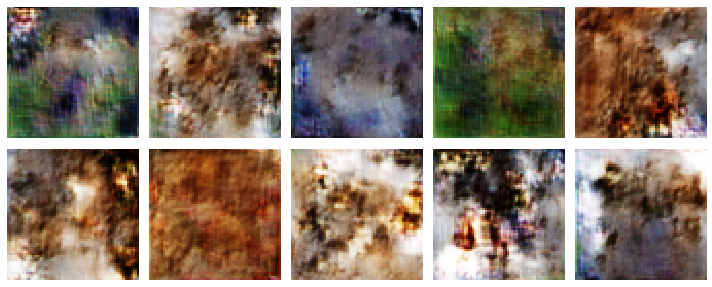

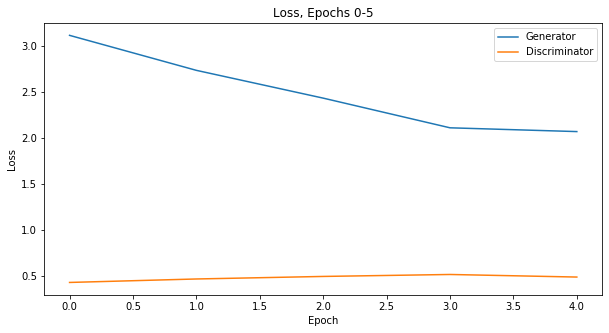

C:\Users\Colin\AppData\Local\Programs\Python\Python37\lib\site-packages\keras\engine\training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Epoch 10


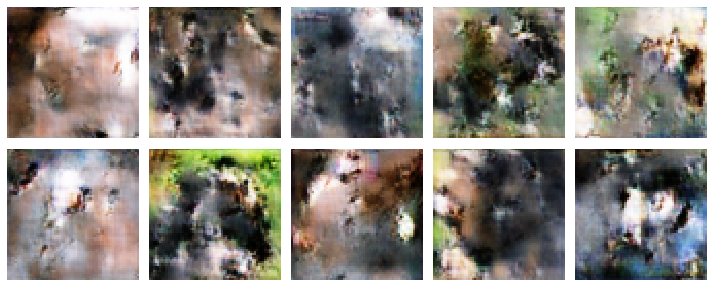

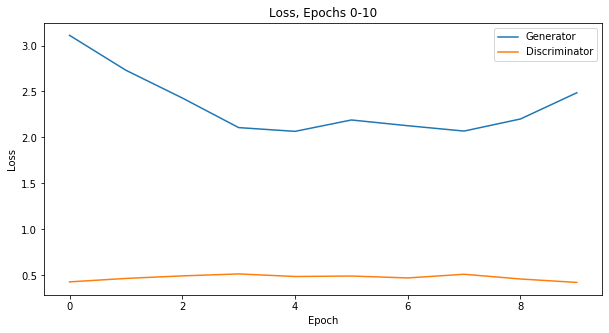

C:\Users\Colin\AppData\Local\Programs\Python\Python37\lib\site-packages\keras\engine\training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Epoch 15


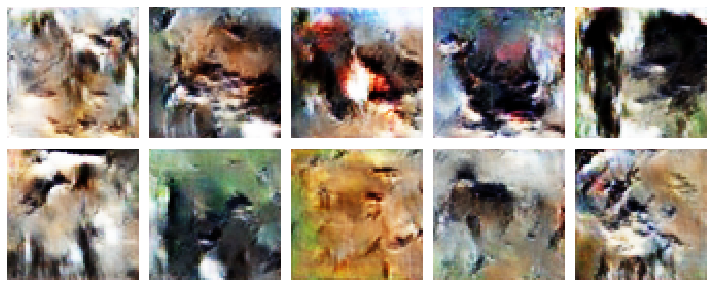

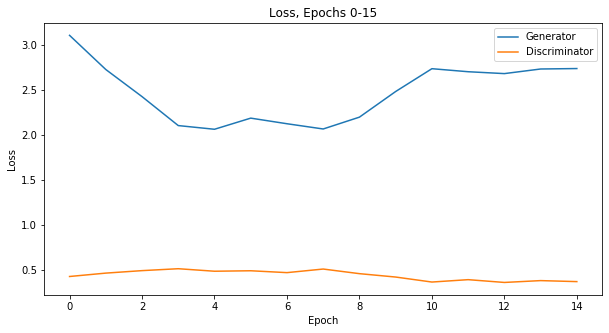

C:\Users\Colin\AppData\Local\Programs\Python\Python37\lib\site-packages\keras\engine\training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Epoch 20


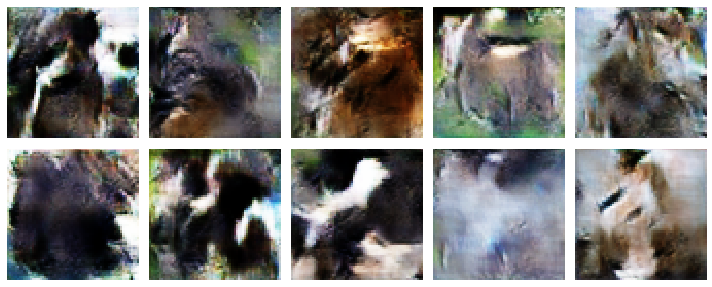

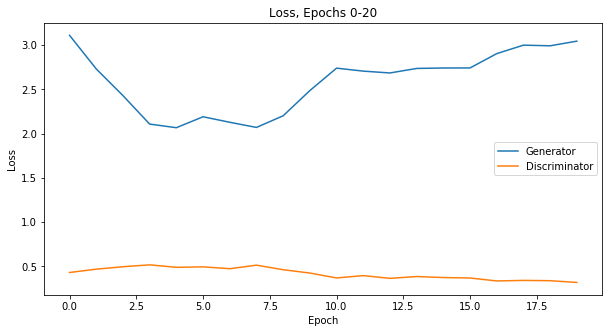

C:\Users\Colin\AppData\Local\Programs\Python\Python37\lib\site-packages\keras\engine\training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Epoch 25


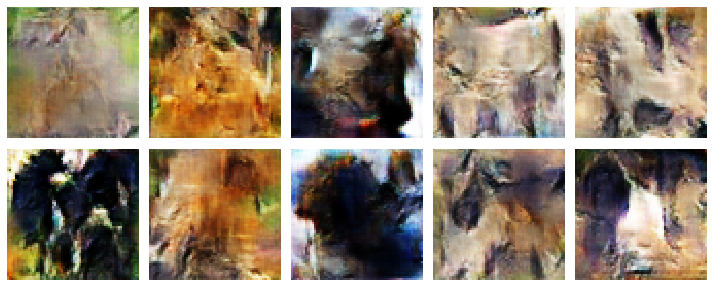

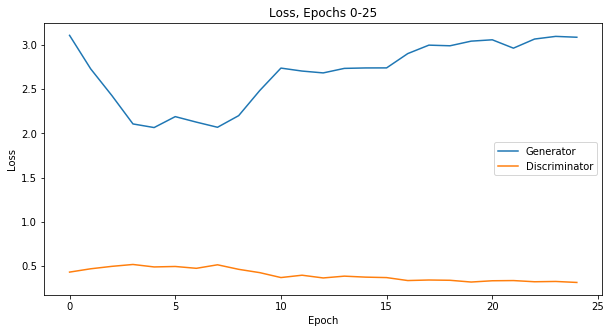

C:\Users\Colin\AppData\Local\Programs\Python\Python37\lib\site-packages\keras\engine\training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Epoch 30


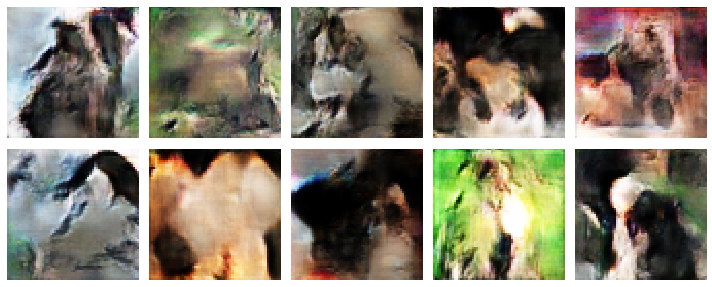

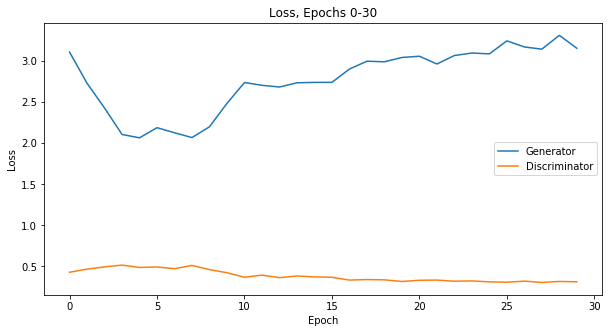

C:\Users\Colin\AppData\Local\Programs\Python\Python37\lib\site-packages\keras\engine\training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Epoch 35


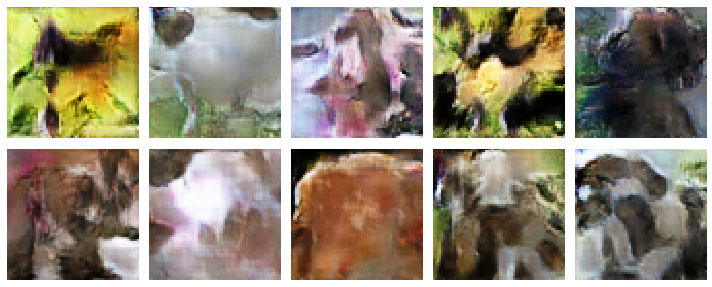

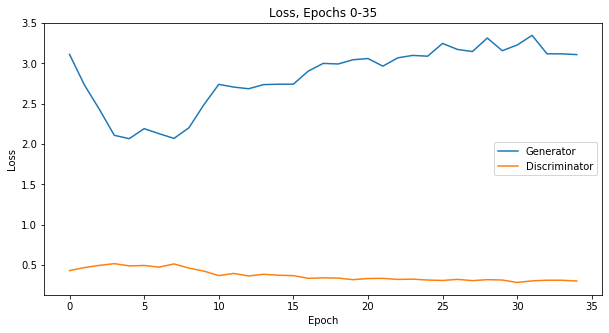

C:\Users\Colin\AppData\Local\Programs\Python\Python37\lib\site-packages\keras\engine\training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Epoch 40


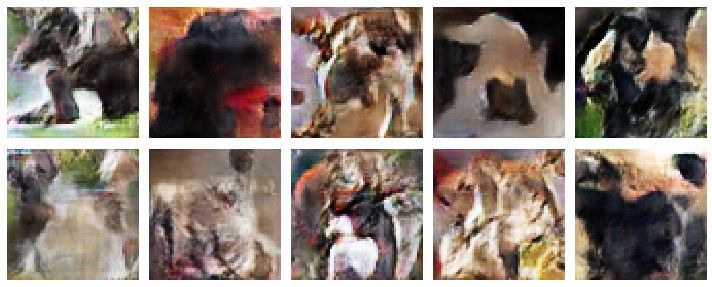

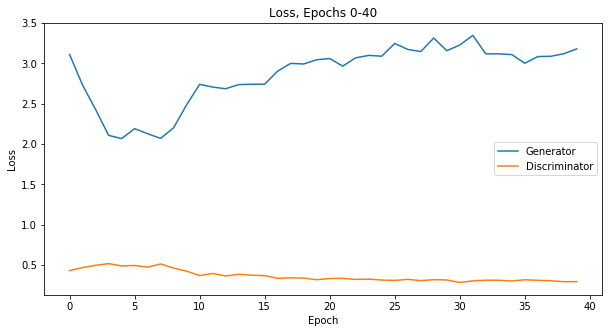

C:\Users\Colin\AppData\Local\Programs\Python\Python37\lib\site-packages\keras\engine\training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Epoch 45


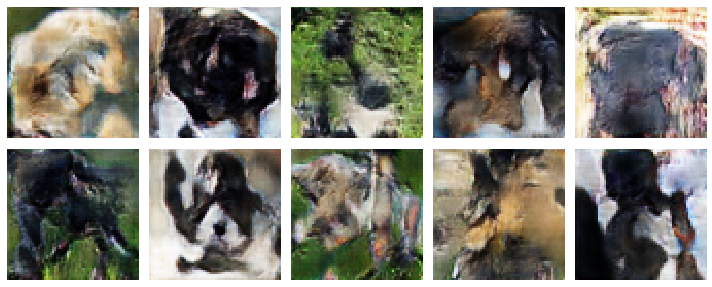

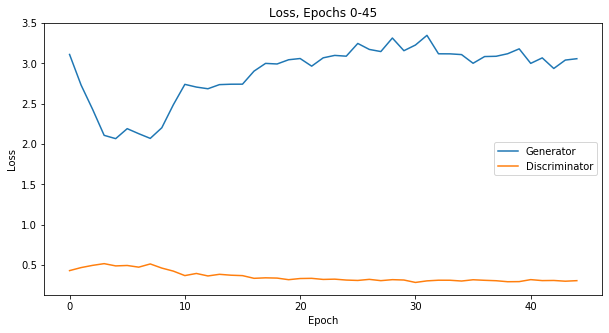

C:\Users\Colin\AppData\Local\Programs\Python\Python37\lib\site-packages\keras\engine\training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Epoch 50


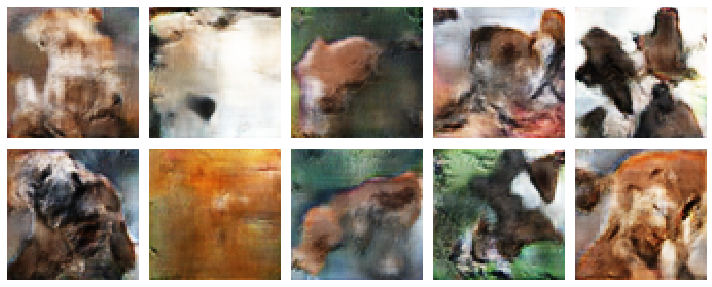

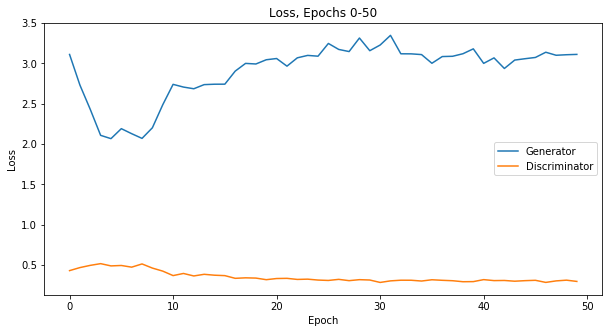

In [30]:
def training(epochs=1, batch_size=32):
    #Loading Data
    batches = X_train.shape[0] / batch_size
    
    discriminator_loss, generator_loss = [], []
    y_valid = np.ones(batch_size)*label_smooth_factor(batch_size)
    for epoch in range(1, epochs+1):
        g_loss = 0; d_loss = 0
        for _ in range(int(batches)):
            
            # Random Noise and Images Set
            X_real, y_real = generate_real_samples(n_samples=batch_size//2)
            
            # Generate Fake Images
            X_fake, y_fake = generate_fake_samples(generator, latent_dim, batch_size//2)
            
            #randomly swap some fake images and real images
            image_batch, generated_images = swap_group(.025,batch_size//2,X_real,X_fake)
            
            # Train Discriminator (Fake and Real)
            d_valid_loss = discriminator.train_on_batch(X_real, y_real)
            d_fake_loss = discriminator.train_on_batch(X_fake, y_fake)            

            d_loss += (d_fake_loss + d_valid_loss)/2
            
            # Train Generator
            X_latent = generate_latent_points(latent_dim, batch_size)

            g_loss += gan.train_on_batch(X_latent, y_valid)
            
        discriminator_loss.append(d_loss/batches)
        generator_loss.append(g_loss/batches)
            
        if epoch % 5 == 0:
            print('Epoch', epoch)
            plot_images(generator)
            plot_loss(epoch, generator_loss, discriminator_loss)
            
training(epochs=50)

In [31]:
# generate images
latent_points = generate_latent_points(latent_dim, 10000)
# generate images
X = generator.predict(latent_points)

print(X.shape, X[0].min(), X[0].max())

(10000, 64, 64, 3) -0.99412423 0.9763687


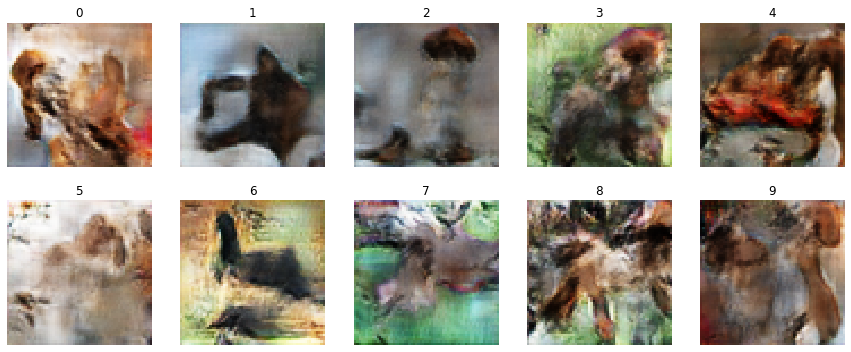

In [32]:
show_images(X, 2, 5)